# Objetivo: Utilizar un dataset abierto de series temporales multivariante que no sea financiero y donde la variable a predecir no tenga estacionalidad. Entrenar un modelo para predecir 100 instantes de tiempo en el futuro con la particularidad que a partir del instante donde se inicia la predicción no se dispone de los valores de las variables regresoras.

Dado que no puedo utilizar los valores de las variables regresoras al momento de la predicción, será necesario entrenar el modelo únicamente con datos históricos de estas variables y entrenarlo utilizando una ventana de tiempo pasado específica para predecir 100 instantes de tiempo a la vez.

Otro enfoque sería utilizar el modelo para predecir solo el próximo instante de tiempo y utilizar eso de input para que el modelo de forma autoregresiva pueda ir prediciendo sobre su último output el próximo instante hasta llegar a 100.

Después de investigar, decido utilizar la librería Darts para entrenar el modelo ya que es una librería que cuenta con múltiples funcionalidades para el procesamiento y preparación de los datos para el entrenamiento y validación.

Adicionalmente, decido utilizar el enfoque de entrenar el modelo sobre una ventana de tiempo especifica para predecir los próximos 100 instantes de tiempo siguientes a la vez, en lugar de uno que lo haga de forma autoregresiva.

Variable a predecir: estudiaré si la variable a predecir tiene estacionalidad y en caso de tenerla, procederé a eliminar la estacionalidad a través de la diferenciación para poder utilizarla como variable target.



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from zipfile import ZipFile
import os

In [2]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 719.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 31.7 MB/s eta 0

In [3]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 2.5 MB/s eta 0:00:00


# Climate Data Multivariate Time-Series

Jena Climate dataset recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).

El dataset consiste en 14 variables registradas cada 10 minutos.

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [4]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path, parse_dates =['Date Time'])
df.head()

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Data Preprocessing

Se trata de un dataset de series temporales multivariante el cual contiene más de 300.000 registros, para este modelo utilizaré un fragmento del dataset consistente de 3000 registros continuos. Los registros se guardan cada 10 minutos con lo cual 6 de ellos equivalen a una hora.

Antes de definir la variable target, exploraré los datos.

In [5]:
#transformación de la columna Date Time a tipo de dato datetime
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [6]:
#reemplazamos el index por la columna Date Time
df = df.set_index('Date Time')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [8]:
#como hemos mencionado antes, nos quedamos con los primero 3000 registros del dataset para trabajar con una serie temporal más pequeña
df = df.iloc[:3000]

In [9]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
df.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-21 19:20:00,981.85,-1.03,273.56,-2.11,92.3,5.66,5.23,0.44,3.32,5.32,1254.36,0.89,1.38,186.1
2009-01-21 19:30:00,981.97,-1.17,273.41,-2.15,93.0,5.61,5.21,0.39,3.31,5.31,1255.16,0.46,0.88,178.0
2009-01-21 19:40:00,982.07,-1.32,273.25,-2.22,93.5,5.55,5.19,0.36,3.29,5.28,1255.98,0.57,1.25,138.7
2009-01-21 19:50:00,982.21,-1.48,273.08,-2.34,93.8,5.48,5.14,0.34,3.26,5.23,1256.93,0.47,0.75,174.4
2009-01-21 20:00:00,982.24,-1.84,272.71,-2.70,93.8,5.33,5.00,0.33,3.17,5.09,1258.74,0.86,1.13,195.2


# Visualización de los datos

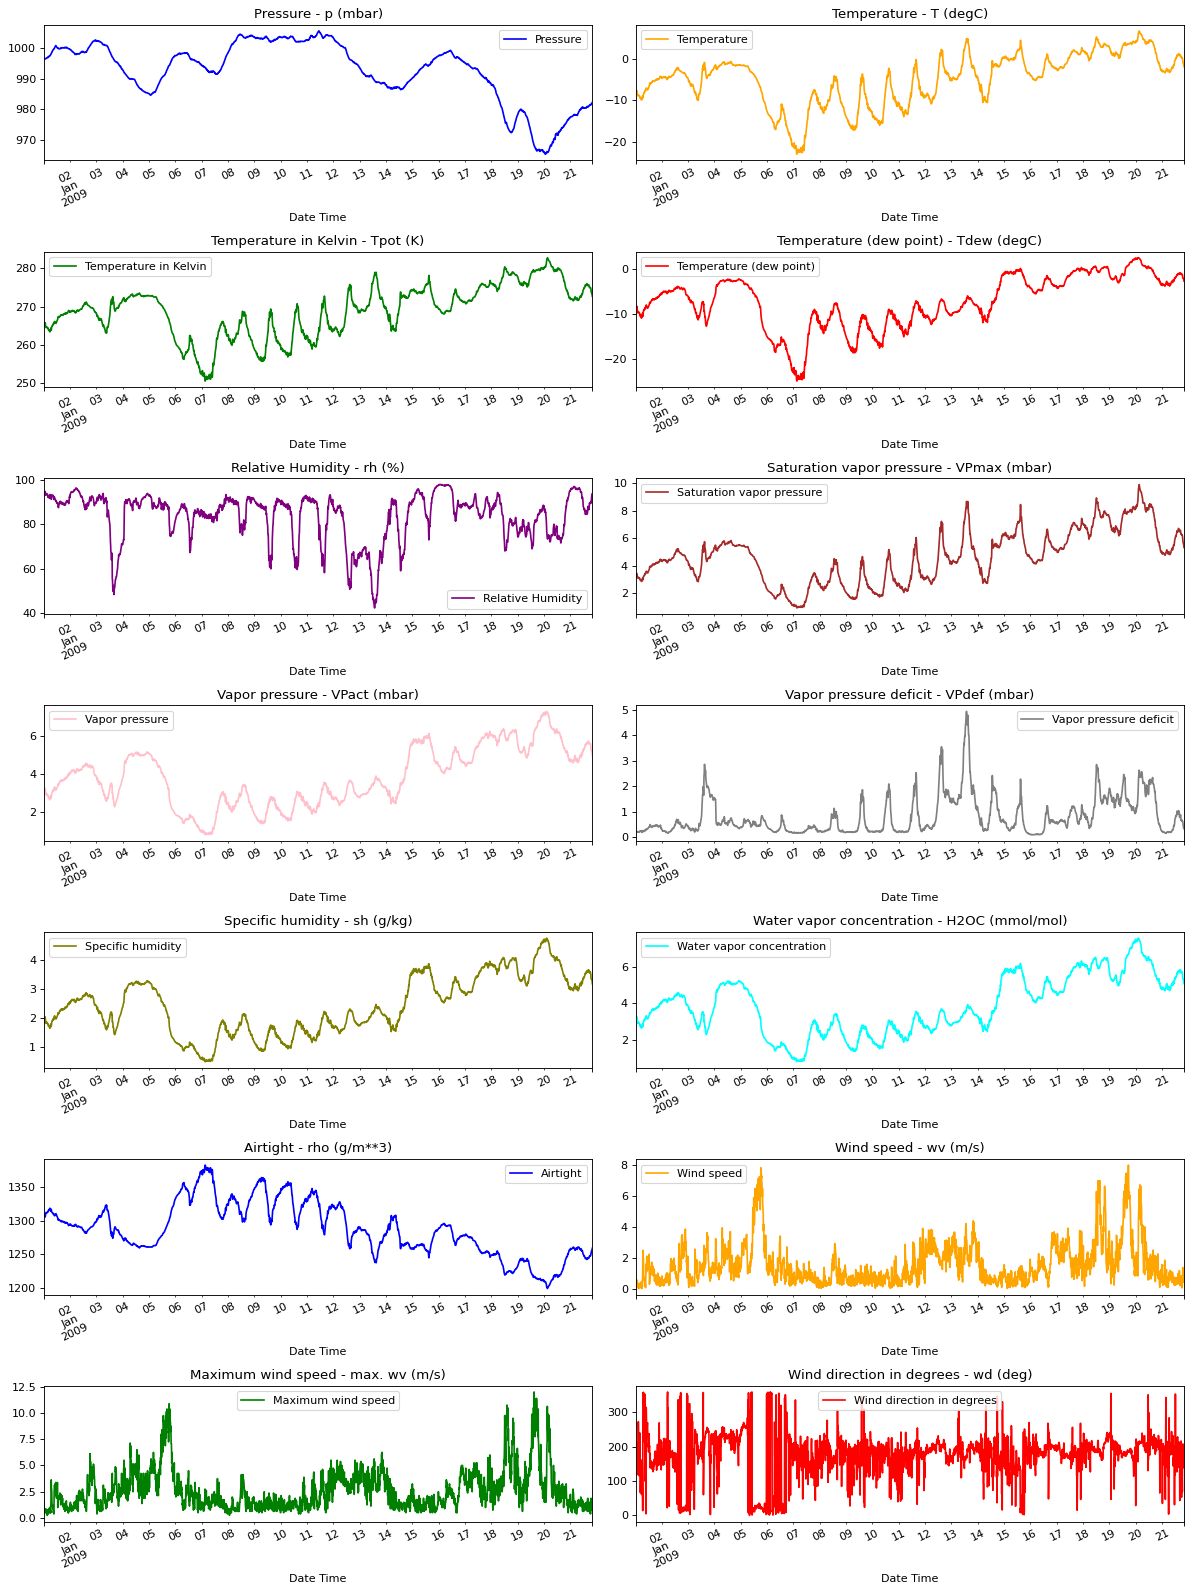

In [11]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]


def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

Escojo como variable target pressure o p (mbar) ya que en principio parece ser la que se diferencia del resto que siguen todas un patrón muy similar. Dado que el requisito para el ejercicio es que la variable a predecir no tenga estacionalidad, haré un análisis para determinar si en efecto lo hay y convertirla en serie estacionaria eliminando el componente estacional antes de utilizarla como variable a predecir.

# Estudio descriptivo

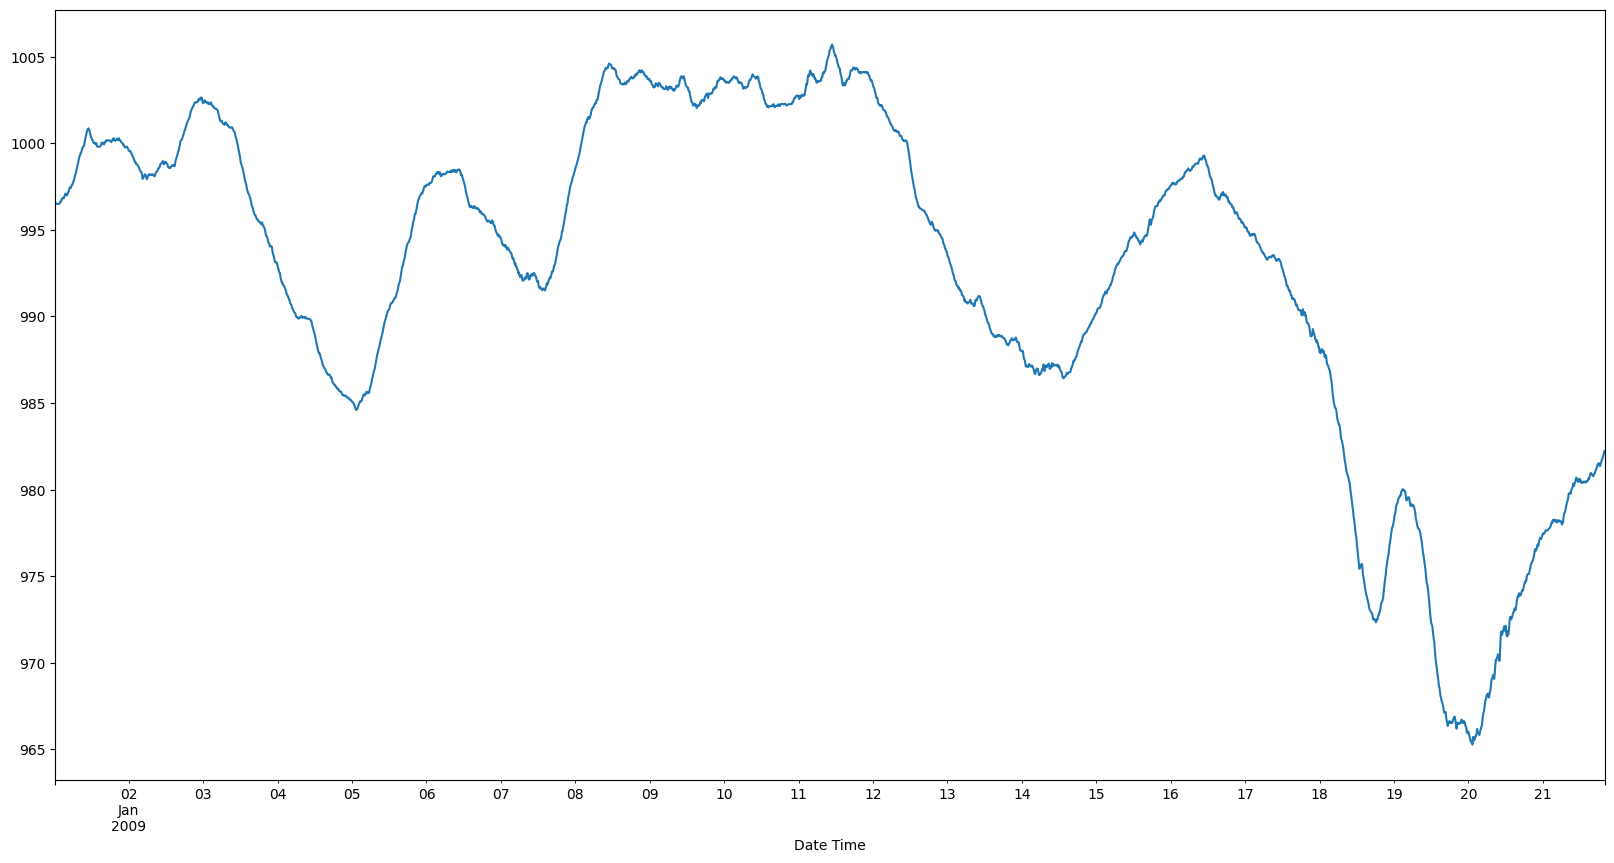

In [12]:
plt.rcParams["figure.figsize"] = (20,10)
df['p (mbar)'].plot()
plt.show()

**Test Dickey Fuller**

Defino una función que calcule el test de Dickey Fuller para la estacionariedad de la serie. De esta forma, en cualquier momento, introduciendo el vector de valores de la serie, obtendré el contraste de hipótesis.

H0: La serie NO es estacionaria
H1: La serie es estacionaria

Por tanto, nos interesará que el contraste de hipótesis sea rechazado (p-valor < 0.05).


In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression ='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [14]:
#probamos con la serie al natural
test_stationarity(df['p (mbar)'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.364866
p-value                           0.398456
#Lags Used                       10.000000
Number of Observations Used    2989.000000
Critical Value (1%)              -3.961802
Critical Value (5%)              -3.411960
Critical Value (10%)             -3.127915
dtype: float64


La serie no es estacionaria, con lo cuál tendré que realizar un proceso de descomposición de la serie para evaluar los factores que habrá que eliminar para volverla estacionaria.

### Descomposición de la serie

En base a la descomposición descriptiva por medias móviles, se extraen las componentes de tendencia y estacionalidad.

**Descomposición aditiva**

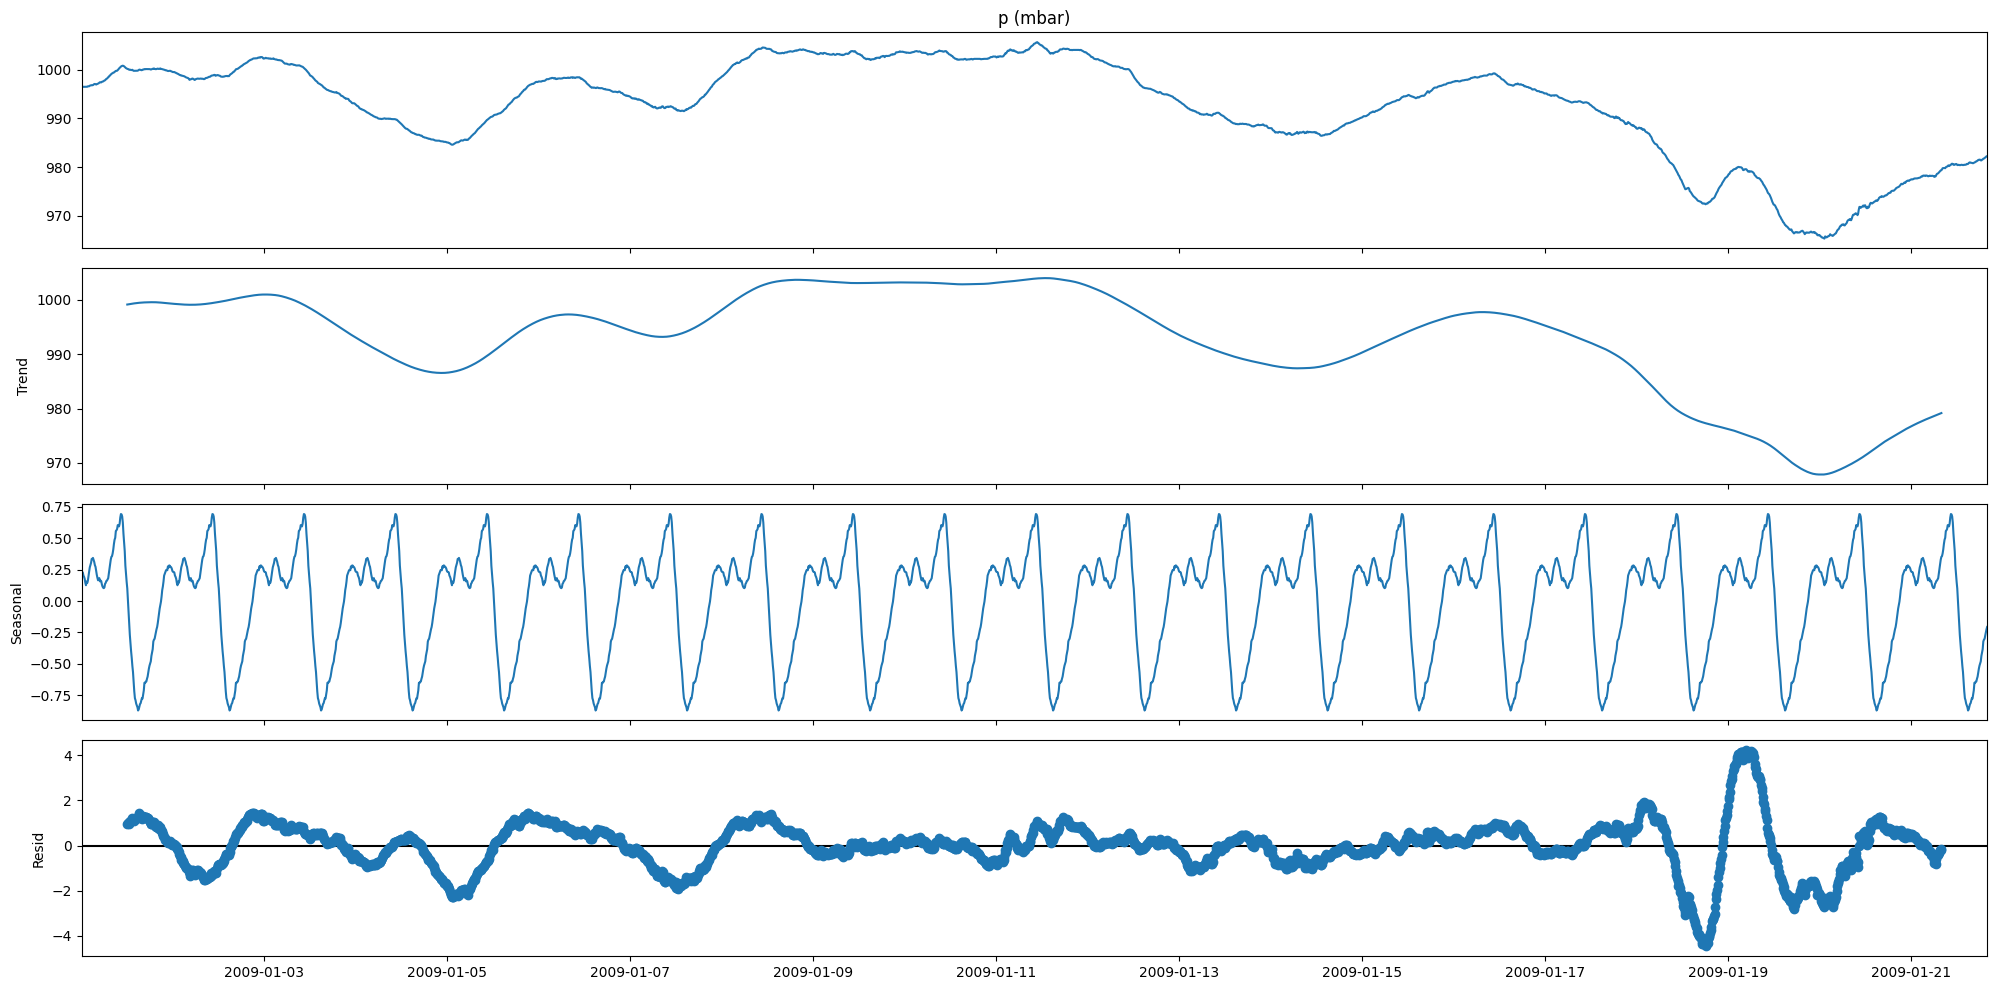

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicar descomposición aditiva
pressure_desc_Ad = seasonal_decompose(df['p (mbar)'], model='additive',period=144)
pressure_desc_Ad.plot()
plt.show()

Evaluamos estacionariedad de los residuos de la descomposición aditiva. Aquí, debido a que la tendencia se calcula por medias móviles, los primeros y últimos valores de la serie son NA, no se calculan. Simplemente saber esto y tener en cuenta solamente los residuos válidos.

In [16]:
#extraemos de la descomposición aditiva los residuos y le aplicamos el test de estacionariedad y luego quitamos los valores nulos NAs
test_stationarity(pressure_desc_Ad.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.303975e+00
p-value                        1.418440e-11
#Lags Used                     2.700000e+01
Number of Observations Used    2.828000e+03
Critical Value (1%)           -3.961975e+00
Critical Value (5%)           -3.412044e+00
Critical Value (10%)          -3.127965e+00
dtype: float64


**Descomposición multiplicativa**

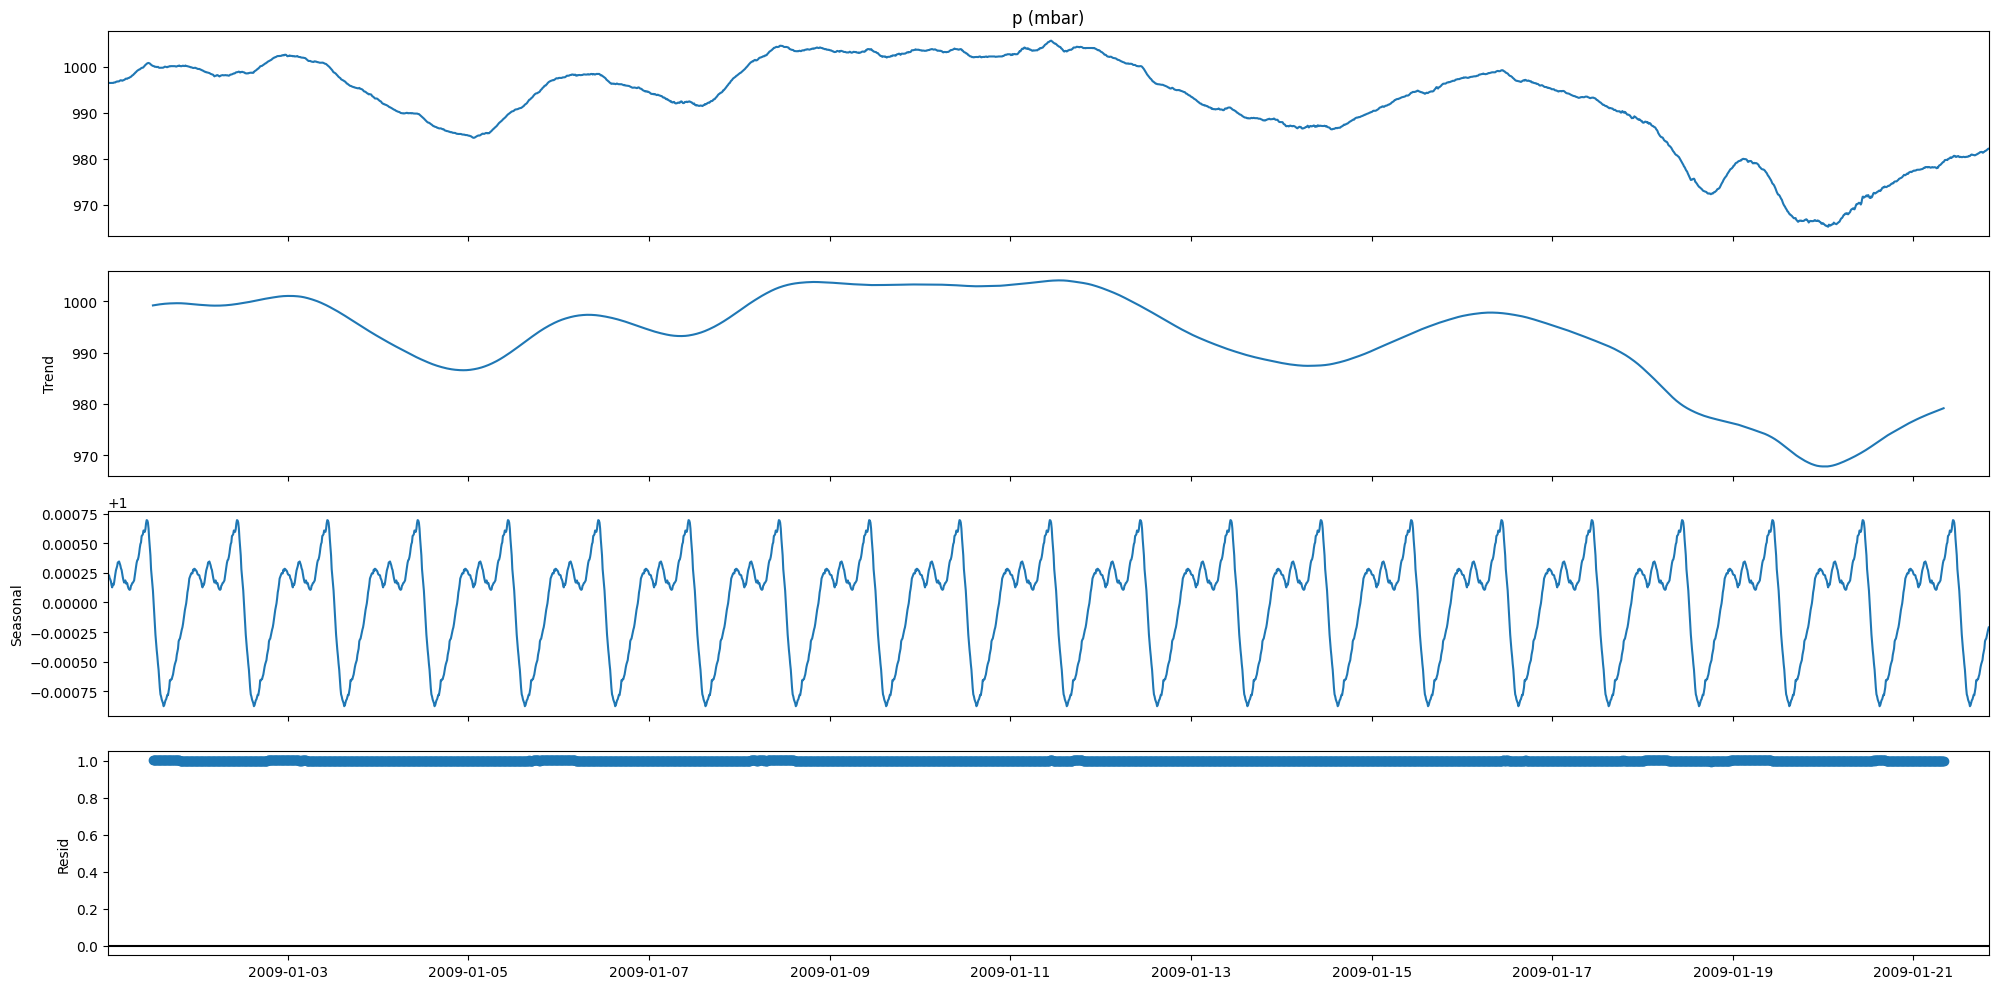

In [17]:
# Aplicar descomposición multiplicativa
pressure_desc_Mul = seasonal_decompose(df['p (mbar)'], model='multiplicative',period=144)
pressure_desc_Mul.plot()
plt.show()

Evaluamos estacionariedad de los residuos de la descomposición Multiplicativa.

In [18]:
#extraemos de la descomposición multiplicativa los residuos y le aplicamos el test de estacionariedad y luego quitamos los valores nulos NAs
test_stationarity(pressure_desc_Mul.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.365993e+00
p-value                        1.020549e-11
#Lags Used                     2.700000e+01
Number of Observations Used    2.828000e+03
Critical Value (1%)           -3.961975e+00
Critical Value (5%)           -3.412044e+00
Critical Value (10%)          -3.127965e+00
dtype: float64


En efecto se puede observar que la variable a predecir p (mbar) tiene estacionalidad, es por ello que procedo a realizar las transformaciones pertinentes para volver la serie estacionaria y adicionalmente eliminar la estacionalidad.

# Transformación de la variable a predecir en no estacionaria

En esta sección voy a extraer la componente identificada para generar una serie residual y comprobar si es estacionaria una vez eliminado el componente estacional.

El esquema es:

1. Estabilización de la varianza. Transformación Logaritmica
2. Diferenciación estacional

Con la serie resultante, comprobaré estacionariedad y será con la que podemos valoraré autocorrelaciones y con la que entrenaré el modelo ya que se cumplirá el requisito de variable a predecir sin estacionalidad.

#### Estabilización de la varianza. Transformación Logaritmica

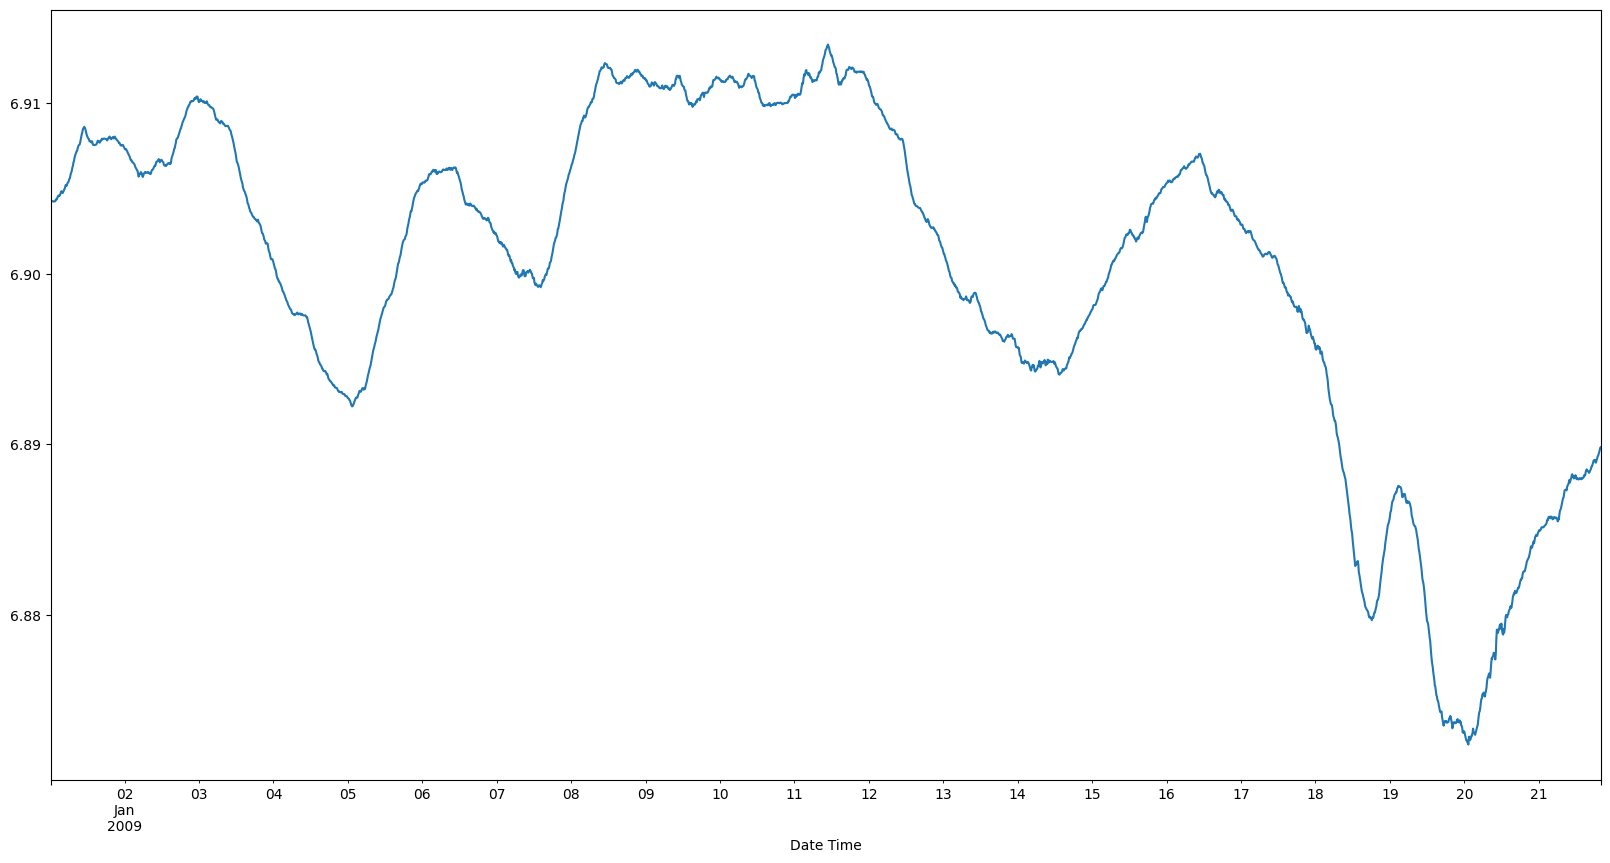

In [19]:
pressureLog = np.log(df['p (mbar)'])
pressureLog.plot()
plt.show()

#### Diferenciación estacional


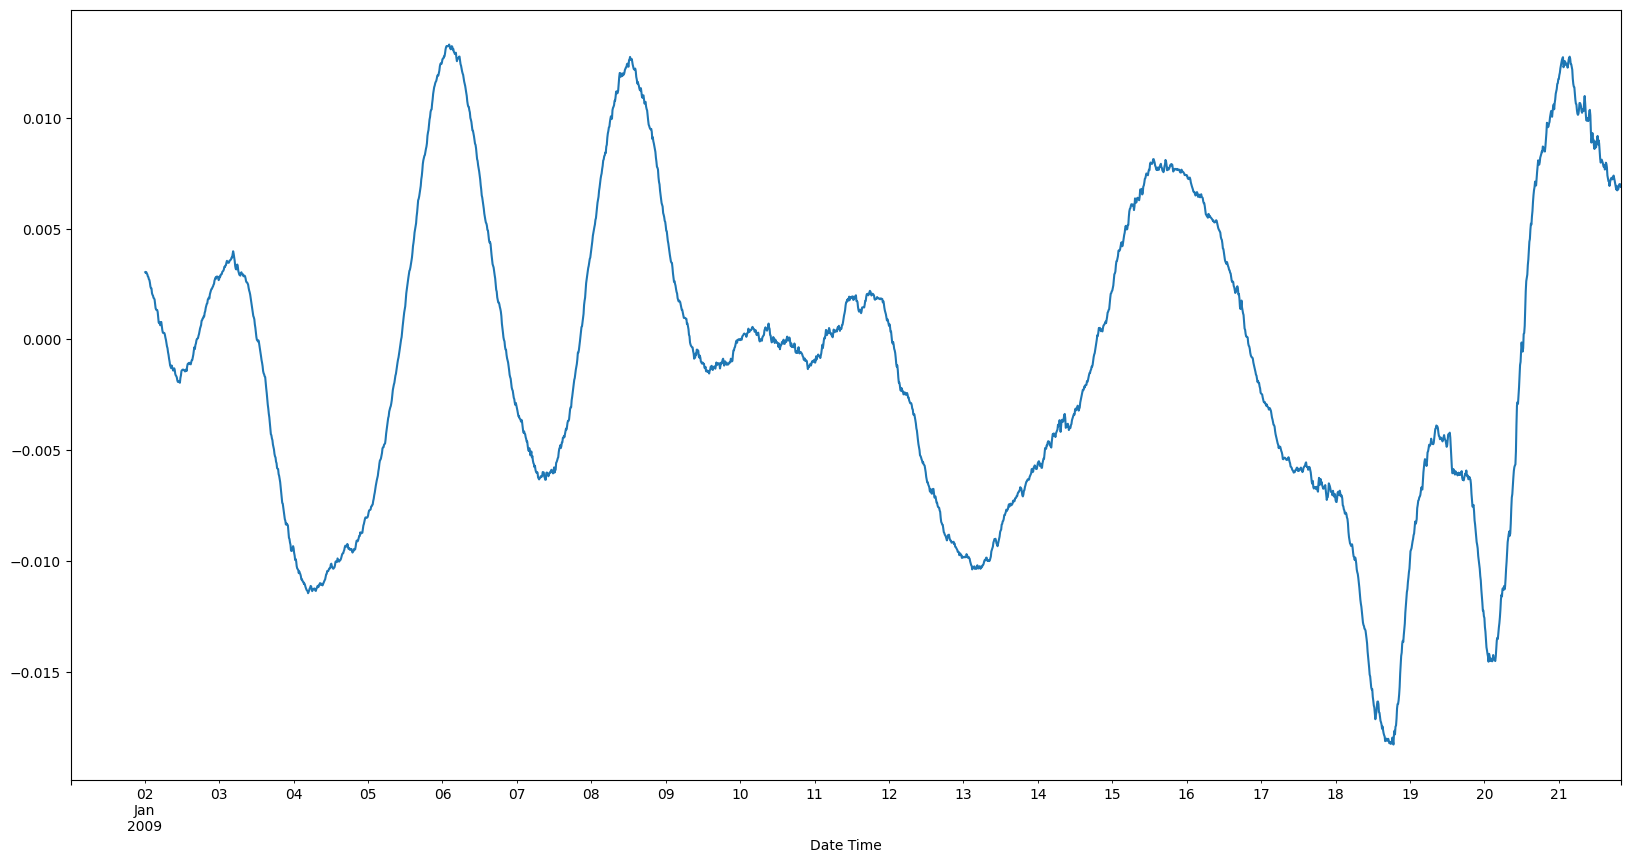

In [20]:
#Toma cada dato y le resta X de T menos 144 para eliminar estacionalidad diaria
pressureLog_diff_144 = pressureLog.diff(periods=144)
pressureLog_diff_144.plot()
plt.show()

#### Comprobación de estacionariedad

In [21]:
test_stationarity(pressureLog_diff_144.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                   -5.064345
p-value                           0.000157
#Lags Used                       19.000000
Number of Observations Used    2836.000000
Critical Value (1%)              -3.961966
Critical Value (5%)              -3.412039
Critical Value (10%)             -3.127962
dtype: float64


**Con la diferenciación estacional diaria en efecto la serie es estacionaria y he eliminado el componente estacional, por lo que procederé a utilizarla para el entrenamiento del modelo.**

# Autocorrelaciones

Evalúo autocorrelaciones para darme una idea de cómo están funcionando las distintas versiones de la variable a predecir, tanto la estacionaria como la no estacionaria.

In [22]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

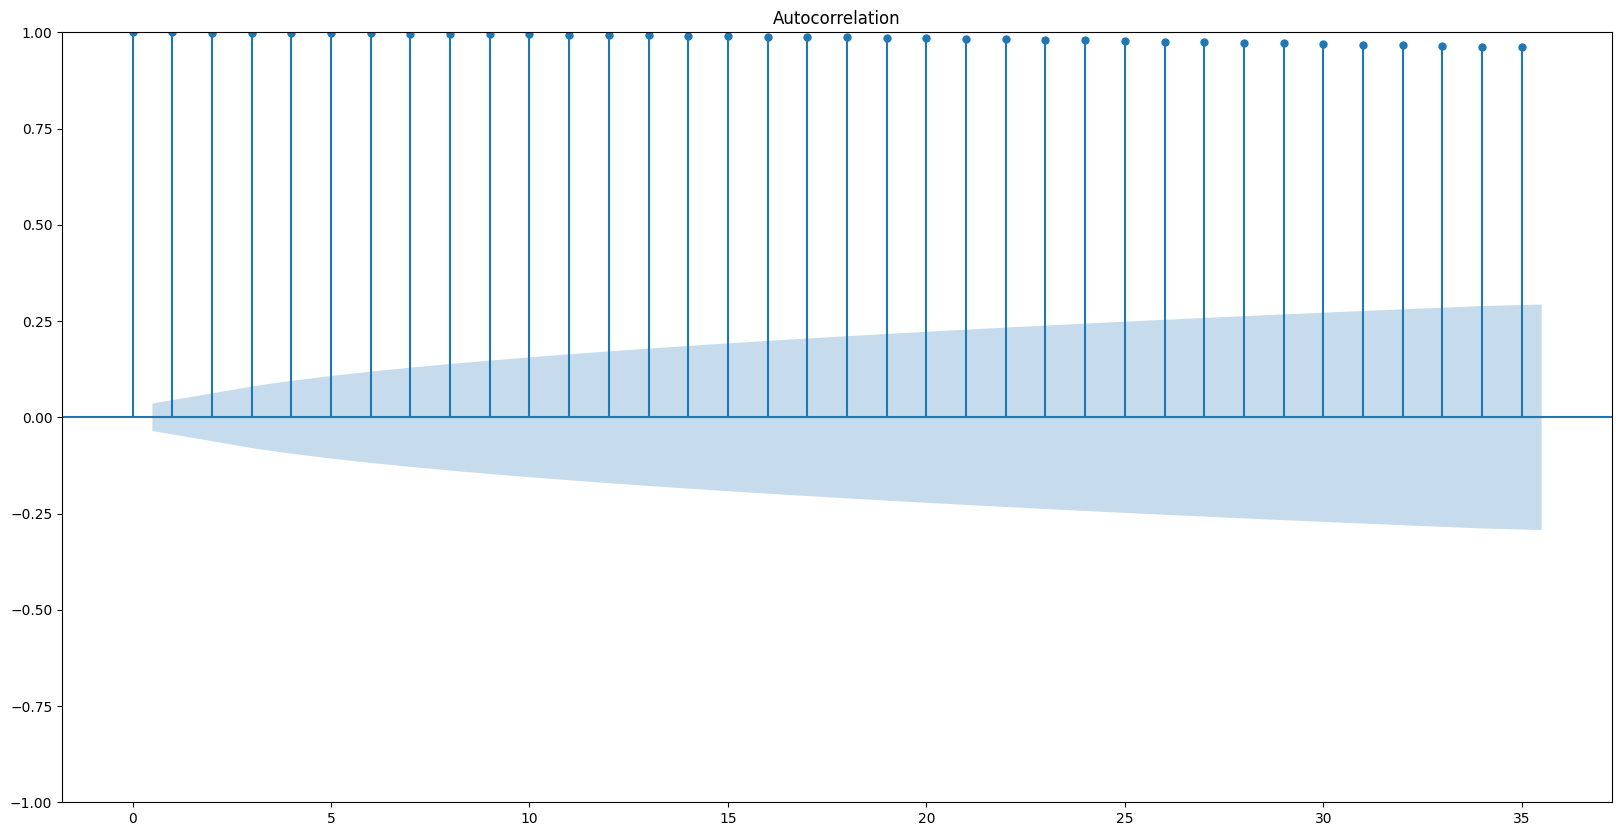

In [23]:
plot_acf(df['p (mbar)'].dropna(inplace=False))
plt.show()

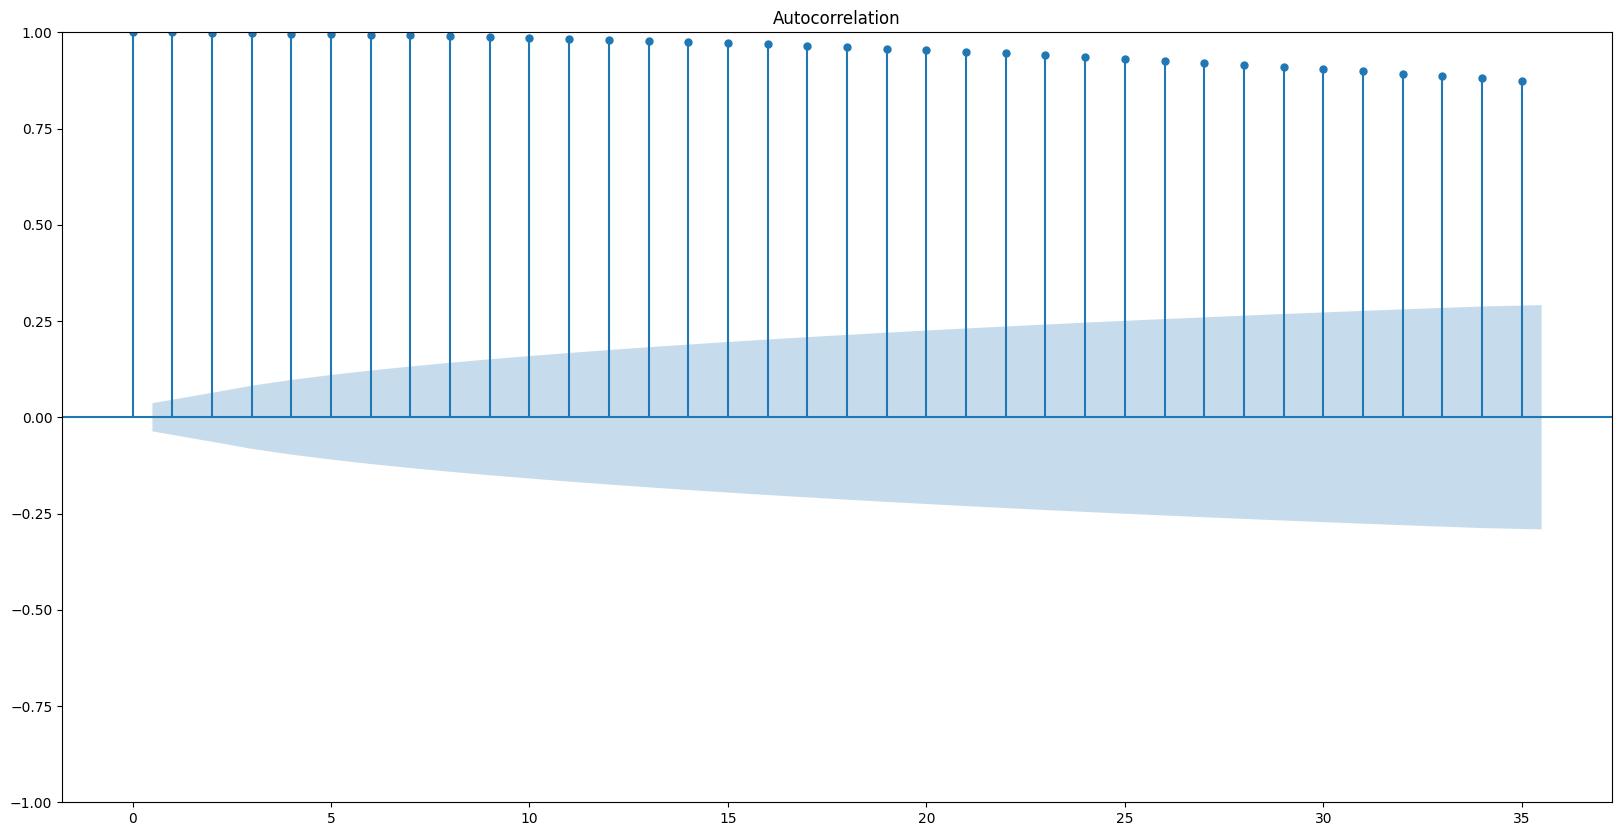

In [24]:
plot_acf(pressureLog_diff_144.dropna(inplace=False)) #, lags=48
plt.show()

In [25]:
# Tests Ljung-box
#este test valora las autocorrelaciones en relacion a una distribucion de contraste
#la H0 del test Ljung-box: la serie NO tiene correlacion
#H1: la serie presenta correlación significativa

sm.stats.acorr_ljungbox(pressureLog_diff_144.dropna(inplace=False), lags=24, return_df=True)

#estos resultados nos indican que aun la serie presenta correlacion

,lb_stat,lb_pvalue
1,2856.110007,0.0
2,5708.877565,0.0
3,8557.285095,0.0
4,11400.285463,0.0
5,14236.856014,0.0
6,17065.991293,0.0
7,19886.675908,0.0
8,22697.882460,0.0
9,25498.418541,0.0
10,28287.200298,0.0


Se puede observar que a pesar de haber diferenciado en lo estacional, la variable target aún contiene autocorrelaciones entre sus lags, esto puede deberse fundamentalmente al componente de tendencia. La serie ha pasado el test de dickey fuller lo que significa que la serie es estacionaria y podemos usarla para entrenamiento del modelo.

# Correlación entre variables

Reviso la coprrelación entre las variables para seleccionar las más útiles de cara a la predicción.

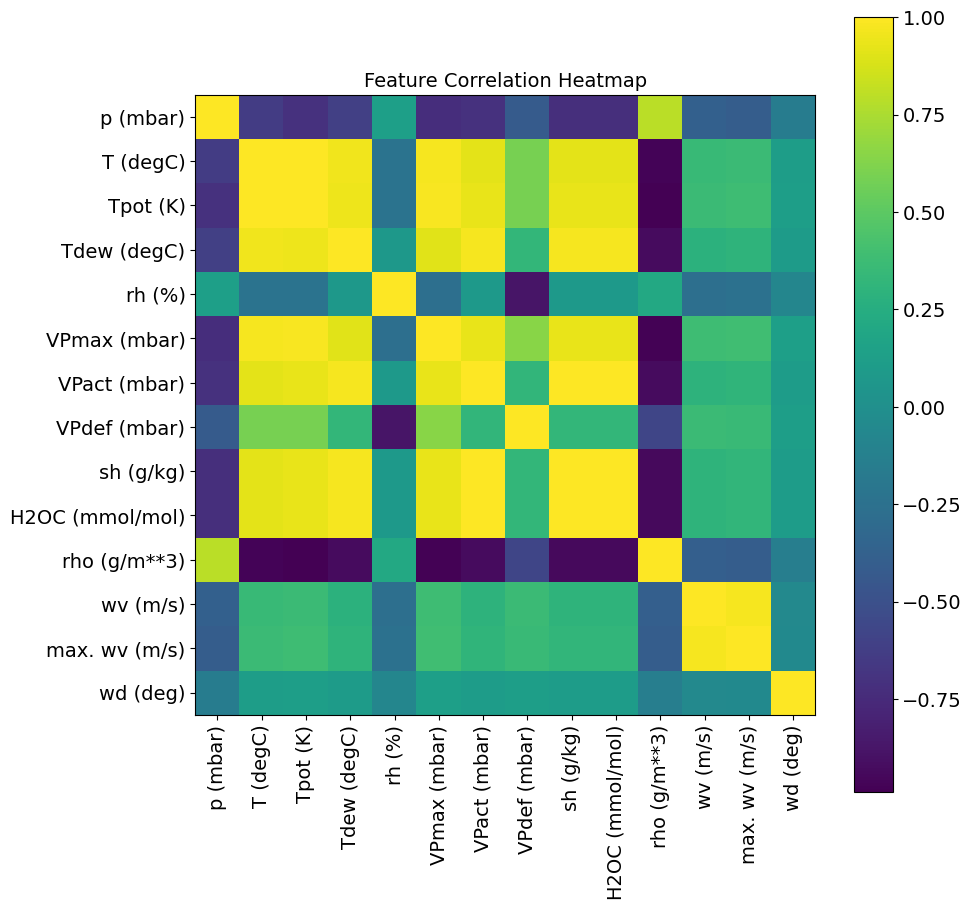

In [26]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [27]:
selected_features_title = ['Pressure', 'Temperature', 'Saturation vapor pressure',
                 'Vapor pressure deficit', 'Specific' 'humidity', 'Airtight', 'Wind speed']
selected_features = ['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)',
"max. wv (m/s)","wd (deg)" ]

Hay variables como Relative Humidity y Specific Humidity que son redundantes, es por ello que selecciono las que reportan más utilidad.

In [28]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-01-21 19:20:00,981.85,-1.03,273.56,-2.11,92.3,5.66,5.23,0.44,3.32,5.32,1254.36,0.89,1.38,186.1
2009-01-21 19:30:00,981.97,-1.17,273.41,-2.15,93.0,5.61,5.21,0.39,3.31,5.31,1255.16,0.46,0.88,178.0
2009-01-21 19:40:00,982.07,-1.32,273.25,-2.22,93.5,5.55,5.19,0.36,3.29,5.28,1255.98,0.57,1.25,138.7


In [29]:
#variable target diferenciada sin estacionalidad
df_diff = pressureLog_diff_144.dropna(inplace=False)
df_diff

,p (mbar)
Date Time,
2009-01-02 00:10:00,0.003036
2009-01-02 00:20:00,0.002996
2009-01-02 00:30:00,0.003036
2009-01-02 00:40:00,0.002976
2009-01-02 00:50:00,0.002936
...,...
2009-01-21 19:20:00,0.006878
2009-01-21 19:30:00,0.007000
2009-01-21 19:40:00,0.006969


In [30]:
#Hago una copia del df inicial y luego me quedo solo con las variables seleccionadas
df_0 = df.copy()
df = df[selected_features].copy()

In [31]:
df.shape

(3000, 9)

In [32]:
df.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32,0.63,214.3


In [33]:
#convertir las series temporales a la clase TimeSeries de darts para poder utilizar su librería para el entrenamiento del modelo
from darts import TimeSeries

ts = TimeSeries.from_dataframe(df)

target_diff = TimeSeries.from_series(df_diff)

In [34]:
#df multivariante con todas las series temporales de variables seleccionadas
ts

<TimeSeries (DataArray) (Date Time: 3000, component: 9, sample: 1)> Size: 216kB
array([[[ 9.9652e+02],
        [-8.0200e+00],
        [ 3.3300e+00],
        ...,
        [ 1.0300e+00],
        [ 1.7500e+00],
        [ 1.5230e+02]],

       [[ 9.9657e+02],
        [-8.4100e+00],
        [ 3.2300e+00],
        ...,
        [ 7.2000e-01],
        [ 1.5000e+00],
        [ 1.3610e+02]],

       [[ 9.9653e+02],
        [-8.5100e+00],
        [ 3.2100e+00],
        ...,
...
        ...,
        [ 5.7000e-01],
        [ 1.2500e+00],
        [ 1.3870e+02]],

       [[ 9.8221e+02],
        [-1.4800e+00],
        [ 5.4800e+00],
        ...,
        [ 4.7000e-01],
        [ 7.5000e-01],
        [ 1.7440e+02]],

       [[ 9.8224e+02],
        [-1.8400e+00],
        [ 5.3300e+00],
        ...,
        [ 8.6000e-01],
        [ 1.1300e+00],
        [ 1.9520e+02]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 24kB 2009-01-01T00:10:00 ... 2009-0...
  * component  (component) object 72B 'p (mbar)' 'T (degC)' ... 'wd (deg)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [35]:
#variable target no estacional
target_diff

<TimeSeries (DataArray) (Date Time: 2856, component: 1, sample: 1)> Size: 23kB
array([[[0.00303597]],

       [[0.0029958 ]],

       [[0.00303594]],

       ...,

       [[0.00696874]],

       [[0.0069985 ]],

       [[0.00688552]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 23kB 2009-01-02T00:10:00 ... 2009-0...
  * component  (component) object 8B 'p (mbar)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Date Time'>

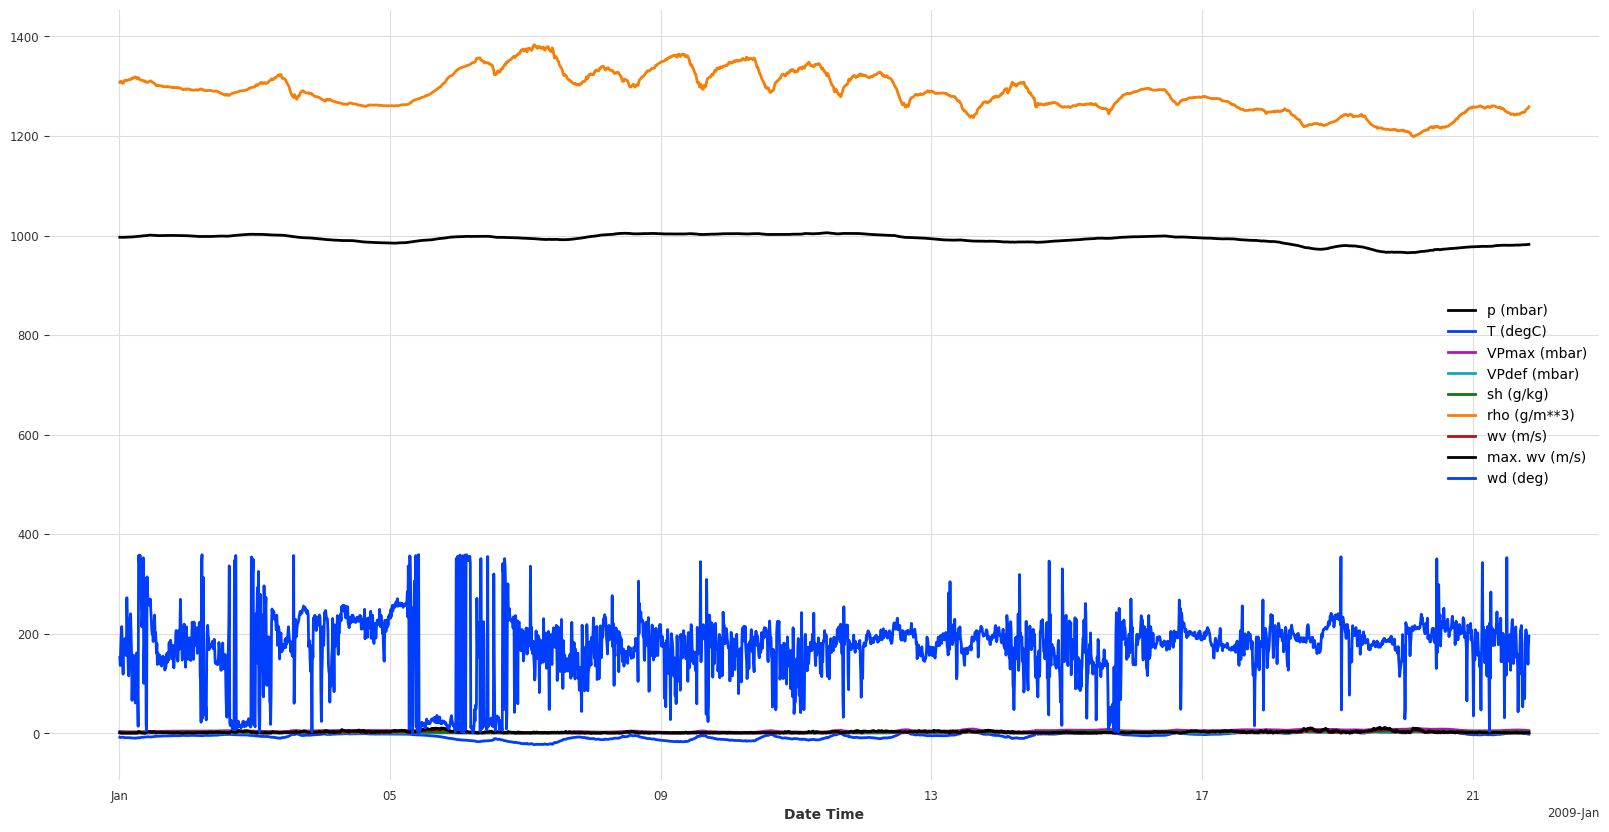

In [36]:
ts.plot()

<Axes: xlabel='Date Time'>

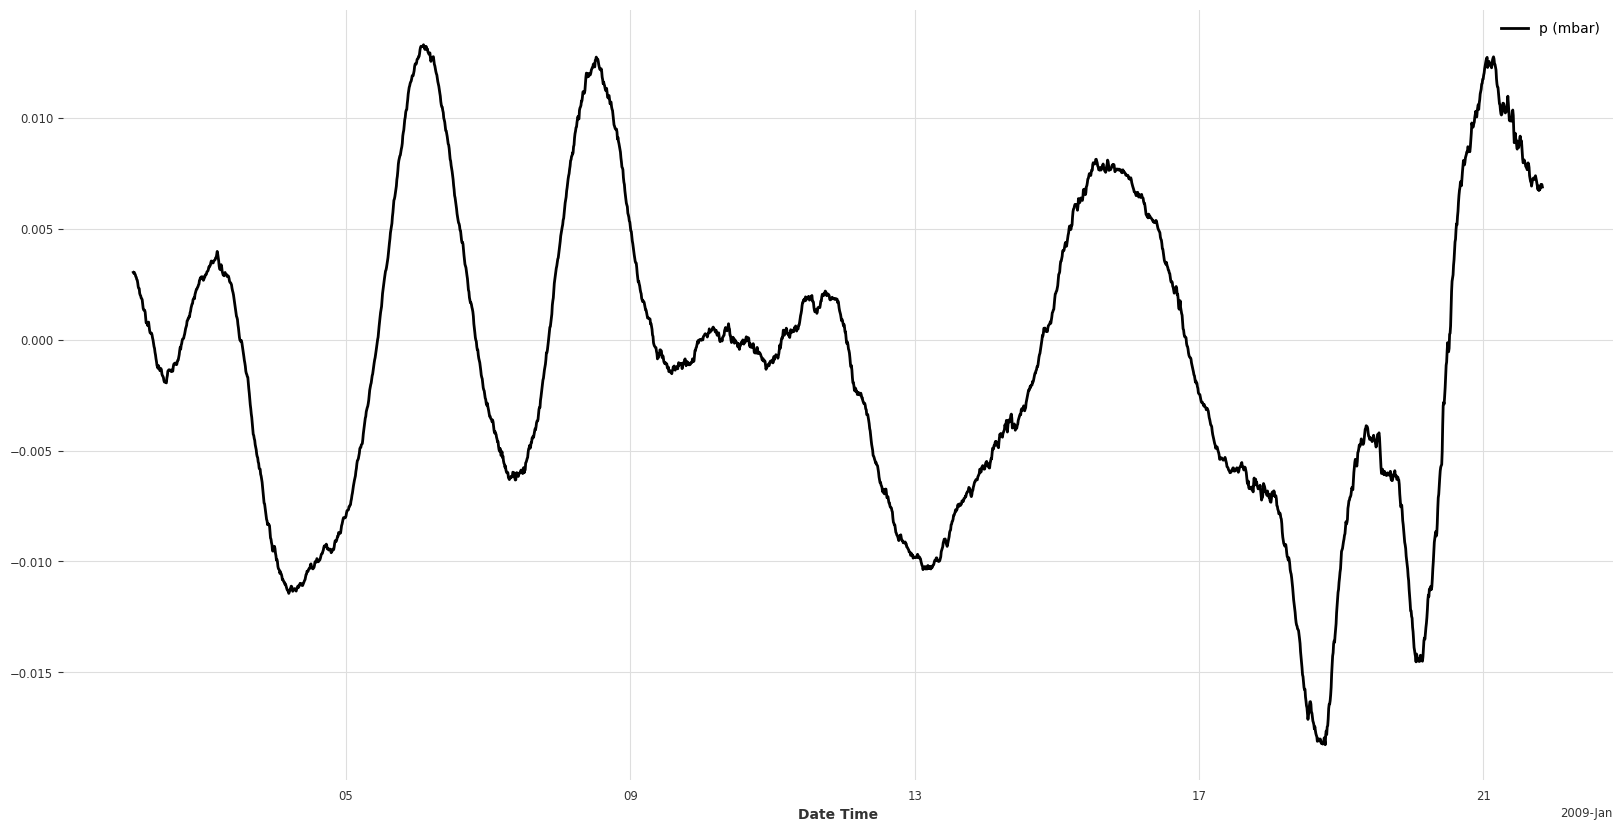

In [37]:
target_diff.plot()

# Partición Train/test del df multivariante y la variable target sin estacionalidad

Para el entrenamiento del modelo utilizaré los datos de train de la variable target sin estacionalidad y los datos de train del resto de variables seleccionadas de nuestro df multivariante. Con lo cual el modelo se estará entrenando sobre datos históricos tanto de la propia variable target como de las otras variables de la serie temporal multivariante.

Dejo como datos de test únicamente los 100 instantes de tiempo en el futuro para todas las variables

In [38]:
#train, test = ts.split_before(0.9)
#df multivariante
train = ts[:-100]
test = ts[-100:]

In [39]:
#train_diff, test_diff = target_diff.split_before(0.9)
#variable target sin estacionalidad
train_diff = target_diff[:-100]
test_diff = target_diff[-100:]

In [40]:
train

<TimeSeries (DataArray) (Date Time: 2900, component: 9, sample: 1)> Size: 209kB
array([[[ 9.9652e+02],
        [-8.0200e+00],
        [ 3.3300e+00],
        ...,
        [ 1.0300e+00],
        [ 1.7500e+00],
        [ 1.5230e+02]],

       [[ 9.9657e+02],
        [-8.4100e+00],
        [ 3.2300e+00],
        ...,
        [ 7.2000e-01],
        [ 1.5000e+00],
        [ 1.3610e+02]],

       [[ 9.9653e+02],
        [-8.5100e+00],
        [ 3.2100e+00],
        ...,
...
        ...,
        [ 9.8000e-01],
        [ 1.8800e+00],
        [ 4.6710e+01]],

       [[ 9.7822e+02],
        [-3.0000e+00],
        [ 4.8900e+00],
        ...,
        [ 5.9000e-01],
        [ 1.2500e+00],
        [ 1.4550e+02]],

       [[ 9.7825e+02],
        [-3.0300e+00],
        [ 4.8800e+00],
        ...,
        [ 4.0000e-01],
        [ 8.8000e-01],
        [ 2.1380e+02]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 23kB 2009-01-01T00:10:00 ... 2009-0...
  * component  (component) object 72B 'p (mbar)' 'T (degC)' ... 'wd (deg)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [41]:
test

<TimeSeries (DataArray) (Date Time: 100, component: 9, sample: 1)> Size: 7kB
array([[[ 9.78220e+02],
        [-2.89000e+00],
        [ 4.93000e+00],
        [ 1.50000e-01],
        [ 3.05000e+00],
        [ 1.25854e+03],
        [ 2.20000e-01],
        [ 8.80000e-01],
        [ 3.42900e+02]],

       [[ 9.78250e+02],
        [-2.71000e+00],
        [ 5.00000e+00],
        [ 1.50000e-01],
        [ 3.09000e+00],
        [ 1.25772e+03],
        [ 3.00000e-01],
        [ 1.13000e+00],
        [ 2.11900e+02]],

...

       [[ 9.82210e+02],
        [-1.48000e+00],
        [ 5.48000e+00],
        [ 3.40000e-01],
        [ 3.26000e+00],
        [ 1.25693e+03],
        [ 4.70000e-01],
        [ 7.50000e-01],
        [ 1.74400e+02]],

       [[ 9.82240e+02],
        [-1.84000e+00],
        [ 5.33000e+00],
        [ 3.30000e-01],
        [ 3.17000e+00],
        [ 1.25874e+03],
        [ 8.60000e-01],
        [ 1.13000e+00],
        [ 1.95200e+02]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 800B 2009-01-21T03:30:00 ... 2009-0...
  * component  (component) object 72B 'p (mbar)' 'T (degC)' ... 'wd (deg)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [42]:
train_diff

<TimeSeries (DataArray) (Date Time: 2756, component: 1, sample: 1)> Size: 22kB
array([[[0.00303597]],

       [[0.0029958 ]],

       [[0.00303594]],

       ...,

       [[0.01241754]],

       [[0.01262252]],

       [[0.01270495]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 22kB 2009-01-02T00:10:00 ... 2009-0...
  * component  (component) object 8B 'p (mbar)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [43]:
test_diff

<TimeSeries (DataArray) (Date Time: 100, component: 1, sample: 1)> Size: 800B
array([[[0.01275711]],

       [[0.01266354]],

       [[0.01242661]],

       [[0.01241511]],

       [[0.01230126]],

       [[0.01216749]],

       [[0.01176508]],

       [[0.01152694]],

       [[0.01140202]],

       [[0.01138076]],

...

       [[0.0067686 ]],

       [[0.00693169]],

       [[0.00672612]],

       [[0.00678662]],

       [[0.00677615]],

       [[0.00687801]],

       [[0.00700022]],

       [[0.00696874]],

       [[0.0069985 ]],

       [[0.00688552]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 800B 2009-01-21T03:30:00 ... 2009-0...
  * component  (component) object 8B 'p (mbar)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# Escalado de datos

Una vez confirmo que los datos de train y test son correctos, dejando como test los instantes de tiempo a futuro para garantizar que no hay data leakage. Procedo a escalar los datos ya que no todas las variables están en el mismo rango y esto puede afectar el entrenamiento de modelo.

Con el Scaler de darts, hago el escalado de cada variable seleccionada, por separado.

También para evitar data leakage, escalamos por separado los datos de train y test, entrenando el scaler con los datos de train y luego transformando con el mismo scaler los datos de test antes de evaluar las métricas.

In [44]:
from darts.dataprocessing.transformers import Scaler

scaler_rho = Scaler()
scaler_pressure_diff = Scaler()
scaler_temperature = Scaler()
scaler_vpmax = Scaler()
scaler_vpdef = Scaler()
scaler_sh = Scaler()
scaler_wv = Scaler()
scaler_max_wv = Scaler()
scaler_wd = Scaler()

series_pressure_diff_scaled = scaler_pressure_diff.fit_transform(train_diff)
series_rho_scaled = scaler_rho.fit_transform(train['rho (g/m**3)'])
series_temperature_scaled = scaler_temperature.fit_transform(train['T (degC)'])
series_vpmax_scaled = scaler_vpmax.fit_transform(train['VPmax (mbar)'])
series_vpdef_scaled = scaler_vpdef.fit_transform(train['VPdef (mbar)'])
series_sh_scaled = scaler_sh.fit_transform(train['sh (g/kg)'])
series_wv_scaled = scaler_wv.fit_transform(train['wv (m/s)'])
series_max_wv_scaled = scaler_max_wv.fit_transform(train["max. wv (m/s)"])
series_wd_scaled = scaler_wd.fit_transform(train["wd (deg)"])

In [45]:
series_pressure_diff_scaled

<TimeSeries (DataArray) (Date Time: 2756, component: 1, sample: 1)> Size: 22kB
array([[[0.67480356]],

       [[0.6735313 ]],

       [[0.6748026 ]],

       ...,

       [[0.97194411]],

       [[0.97843656]],

       [[0.98104739]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 22kB 2009-01-02T00:10:00 ... 2009-0...
  * component  (component) object 8B 'p (mbar)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Debido a la diferenciación para eliminar la estacionalidad de la variable a predecir, al restarsele 144 valores anteriores a todos los data points (los cuáles representan el mismo instante de tiempo el día anterior), esto resulta en una longitud menor de la serie temporal de la variable a predecir, es por ello, que para que todas las variables que usaré en el entrenamiento tengan las mismas fechas y tiempos, elimino los primeros 144 data points del resto de variables.

In [46]:
series_rho_scaled[144:]

<TimeSeries (DataArray) (Date Time: 2756, component: 1, sample: 1)> Size: 22kB
array([[[0.51963648]],

       [[0.52142162]],

       [[0.52131343]],

       ...,

       [[0.33122363]],

       [[0.32759926]],

       [[0.32841069]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 22kB 2009-01-02T00:10:00 ... 2009-0...
  * component  (component) object 8B 'rho (g/m**3)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# Train and predict

Probaré entrenando con dos de los algoritmos con mejor performance en materia de forecasting y que tienen capacidad para ser entrenados con series multivariantes. El LGBM y el NBeats.

Entreno ambos algoritmos con las series temporales escaladas, especificando en ambos casos utilizar los 100 instantes de tiempo anteriores para predecir los 100 instantes de tiempo en el futuro.

Luego genero la predicción indicando únicamente el número de instantes en el tiempo a predecir, es importante destacar que la predicción se lleva acabo únicamente con el modelo entrenado con la data histórica tanto de la variable target sin estacionalidad como con el resto de variables de la serie temporal multivariante. **Por lo que al momento de la predicción, no se incluyen los valores de las variables regresoras.**

In [47]:
past_cov1 = series_rho_scaled[144:]
past_cov2 = series_temperature_scaled[144:]
past_cov3 = series_vpmax_scaled[144:]
past_cov4 = series_vpdef_scaled[144:]
past_cov5 = series_sh_scaled[144:]
past_cov6 = series_wv_scaled[144:]
past_cov7 = series_max_wv_scaled[144:]
past_cov8 = series_wd_scaled[144:]

In [48]:
combined_ts = past_cov1.concatenate(past_cov2, axis=1)
combined_ts = combined_ts.concatenate(past_cov3, axis=1)
combined_ts = combined_ts.concatenate(past_cov4, axis=1)
combined_ts = combined_ts.concatenate(past_cov5, axis=1)
combined_ts = combined_ts.concatenate(past_cov6, axis=1)
combined_ts = combined_ts.concatenate(past_cov7, axis=1)
combined_ts = combined_ts.concatenate(past_cov8, axis=1)
combined_ts

<TimeSeries (DataArray) (Date Time: 2756, component: 8, sample: 1)> Size: 176kB
array([[[0.51963648],
        [0.61757799],
        [0.37919463],
        ...,
        [0.10088272],
        [0.09617021],
        [0.42109371]],

       [[0.52142162],
        [0.61522979],
        [0.37695749],
        ...,
        [0.09836066],
        [0.10638298],
        [0.41440437]],

       [[0.52131343],
        [0.61556525],
        [0.37695749],
        ...,
...
        ...,
        [0.11727617],
        [0.1387234 ],
        [0.12985674]],

       [[0.32759926],
        [0.67125126],
        [0.44071588],
        ...,
        [0.06809584],
        [0.08510638],
        [0.40520653]],

       [[0.32841069],
        [0.67024488],
        [0.43959732],
        ...,
        [0.04413619],
        [0.05361702],
        [0.59557389]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 22kB 2009-01-02T00:10:00 ... 2009-0...
  * component  (component) object 64B 'rho (g/m**3)' 'T (degC)' ... 'wd (deg)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [49]:
from darts.models import LightGBMModel

# predicting atmospheric pressure

target = series_pressure_diff_scaled

past_cov = combined_ts

# values corresponding to the forecasted period
lgbm = LightGBMModel(
    lags=100,
    lags_past_covariates=100,
    output_chunk_length=100,
    verbose=-1
)
lgbm.fit(target, past_covariates=past_cov)
pred1 = lgbm.predict(100)
pred1.values()

array([[0.98029946],
       [0.97813699],
       [0.97842291],
       [0.97016853],
       [0.97486081],
       [0.97290215],
       [0.9718207 ],
       [0.97346568],
       [0.97323652],
       [0.96960003],
       [0.96854495],
       [0.96838256],
       [0.96552268],
       [0.96586828],
       [0.96582327],
       [0.9581053 ],
       [0.94389804],
       [0.92805811],
       [0.90081993],
       [0.89532401],
       [0.87581134],
       [0.86316646],
       [0.87542936],
       [0.86122955],
       [0.85834267],
       [0.84597138],
       [0.84556203],
       [0.84864808],
       [0.83915247],
       [0.8357403 ],
       [0.8422961 ],
       [0.84614932],
       [0.84271156],
       [0.83569194],
       [0.84334717],
       [0.83471315],
       [0.83885191],
       [0.83522981],
       [0.86222871],
       [0.86286884],
       [0.86495267],
       [0.85221256],
       [0.85537101],
       [0.88140192],
       [0.88556323],
       [0.87915417],
       [0.86902506],
       [0.882

In [50]:
pred1

<TimeSeries (DataArray) (Date Time: 100, component: 1, sample: 1)> Size: 800B
array([[[0.98029946]],

       [[0.97813699]],

       [[0.97842291]],

       [[0.97016853]],

       [[0.97486081]],

       [[0.97290215]],

       [[0.9718207 ]],

       [[0.97346568]],

       [[0.97323652]],

       [[0.96960003]],

...

       [[0.8360346 ]],

       [[0.830187  ]],

       [[0.81173039]],

       [[0.80352823]],

       [[0.82328341]],

       [[0.85142342]],

       [[0.82291114]],

       [[0.82417531]],

       [[0.80023278]],

       [[0.78970548]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 800B 2009-01-21T03:30:00 ... 2009-0...
  * component  (component) object 8B 'p (mbar)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

**Antes de computar métricas, debo transformar con el mismo scaler usado para los datos de train, el set de test, ya que el entrenamiento del modelo se hizo con los datos escalados y por ende su predicción será en ese rango. En este sentido, para que el cómputo de métricas sea correcto, deben transformarse (escalarse con el mismo scaler) los datos de test también.**

In [51]:
y_test = scaler_pressure_diff.transform(test_diff)
y_test

<TimeSeries (DataArray) (Date Time: 100, component: 1, sample: 1)> Size: 800B
array([[[0.98269945]],

       [[0.97973578]],

       [[0.9722315 ]],

       [[0.97186725]],

       [[0.96826149]],

       [[0.96402445]],

       [[0.95127912]],

       [[0.94373652]],

       [[0.93977996]],

       [[0.93910643]],

...

       [[0.79302635]],

       [[0.79819208]],

       [[0.79168089]],

       [[0.79359711]],

       [[0.79326571]],

       [[0.7964917 ]],

       [[0.80036246]],

       [[0.79936549]],

       [[0.8003081 ]],

       [[0.79672959]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 800B 2009-01-21T03:30:00 ... 2009-0...
  * component  (component) object 8B 'p (mbar)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [52]:
from darts.metrics import mae, rmse, mape

# Compute MAE (Mean Absolute Error)
mae_val = mae(y_test, pred1)
print(f"MAE: {mae_val}")

# Compute RMSE (Root Mean Squared Error)
rmse_val = rmse(y_test, pred1)
print(f"RMSE: {rmse_val}")

# Compute MAPE (Mean Absolute Percentage Error)
mape_val = mape(y_test, pred1)
print(f"MAPE: {mape_val}")

MAE: 0.026707803880946512
RMSE: 0.033757364888726174
MAPE: 3.0483724626949584


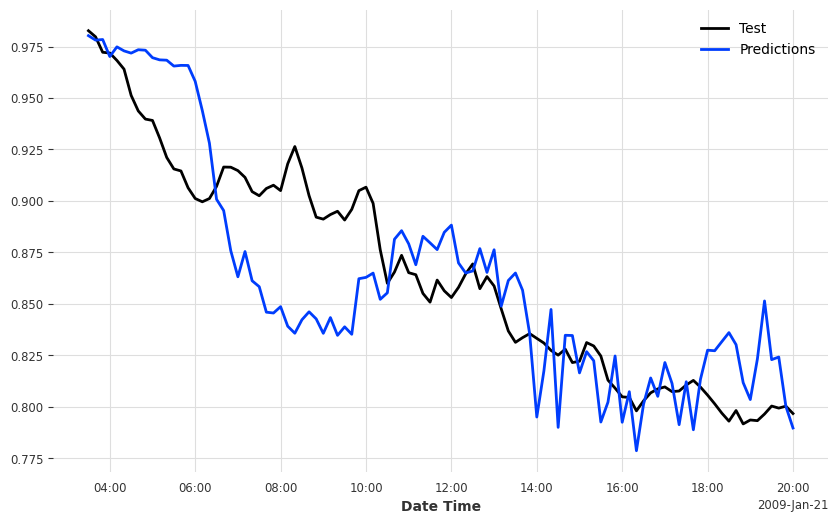

In [53]:
# Plot the results
plt.figure(figsize=(10, 6))
y_test.plot(label="Test")
pred1.plot(label="Predictions")
plt.legend()
plt.show()

In [54]:
from darts.models import NBEATSModel

# changing the activation function of the encoder/decoder to LeakyReLU
nbeats = NBEATSModel(
    input_chunk_length=100,
    output_chunk_length=100,
    activation='LeakyReLU',
    n_epochs=27
)
nbeats.fit(target, past_covariates=past_cov)
pred2 = nbeats.predict(100)
pred2.values()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 13.2 M | train
-------------------------------------------------------------
13.2 M    Trainable params
6.7 K     Non-trainable params
13.2 M    Total params
52.968    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=27` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[0.89865907],
       [0.86549454],
       [0.86116873],
       [0.90434305],
       [0.89078721],
       [0.9091061 ],
       [0.87998812],
       [0.8825277 ],
       [0.91734832],
       [0.904016  ],
       [0.89892058],
       [0.88675118],
       [0.92972822],
       [0.8564558 ],
       [0.9270149 ],
       [0.915698  ],
       [0.88704149],
       [0.89310108],
       [0.90240307],
       [0.87731463],
       [0.84456024],
       [0.85686222],
       [0.9248572 ],
       [0.8725984 ],
       [0.86739461],
       [0.91910664],
       [0.87583996],
       [0.88949438],
       [0.90801662],
       [0.87668281],
       [0.9434679 ],
       [0.86220551],
       [0.88283929],
       [0.86401429],
       [0.9239948 ],
       [0.85755726],
       [0.85877564],
       [0.8764911 ],
       [0.90172677],
       [0.88337733],
       [0.89635356],
       [0.86634082],
       [0.89881726],
       [0.86309035],
       [0.9021918 ],
       [0.87248348],
       [0.88814225],
       [0.907

In [55]:
pred2

<TimeSeries (DataArray) (Date Time: 100, component: 1, sample: 1)> Size: 800B
array([[[0.89865907]],

       [[0.86549454]],

       [[0.86116873]],

       [[0.90434305]],

       [[0.89078721]],

       [[0.9091061 ]],

       [[0.87998812]],

       [[0.8825277 ]],

       [[0.91734832]],

       [[0.904016  ]],

...

       [[0.81768362]],

       [[0.81600697]],

       [[0.78607045]],

       [[0.815968  ]],

       [[0.8199484 ]],

       [[0.81017094]],

       [[0.84547298]],

       [[0.80165605]],

       [[0.78509554]],

       [[0.78721298]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 800B 2009-01-21T03:30:00 ... 2009-0...
  * component  (component) object 8B 'p (mbar)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [56]:

# Compute MAE (Mean Absolute Error)
mae_val = mae(y_test, pred2)
print(f"MAE: {mae_val}")

# Compute RMSE (Root Mean Squared Error)
rmse_val = rmse(y_test, pred2)
print(f"RMSE: {rmse_val}")

# Compute MAPE (Mean Absolute Percentage Error)
mape_val = mape(y_test, pred2)
print(f"MAPE: {mape_val}")

MAE: 0.027469905085022138
RMSE: 0.03506295250185466
MAPE: 3.1100839792208337


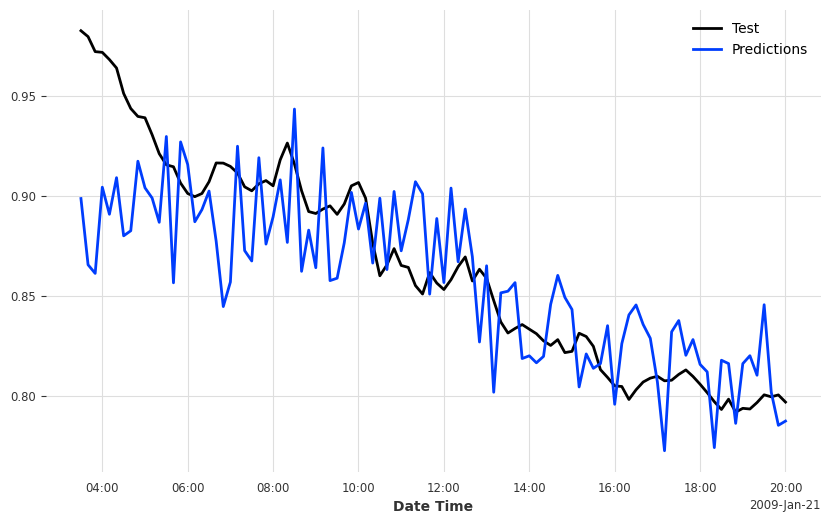

In [57]:
# Plot the results
plt.figure(figsize=(10, 6))
y_test.plot(label="Test")
pred2.plot(label="Predictions")
plt.legend()
plt.show()

El performance del modelo entrenado con el lgbm es ligeramente mejor, por lo que decido entrenar ambos algoritmos con las variables que mejor funcionen y escoger el de mejor performance como modelo final.

# Feature Selection, final model

Probamos con todas las variables seleccionadas inicialmente y la combinación de ellas que mejor ha funcionado para el entrenamiento del modelo con mejor performance ha sido: Temperature y Airtight (rho)

A continuación dejo los resultados finales.

In [58]:
combined_ts = past_cov1.concatenate(past_cov2, axis=1)
combined_ts

<TimeSeries (DataArray) (Date Time: 2756, component: 2, sample: 1)> Size: 44kB
array([[[0.51963648],
        [0.61757799]],

       [[0.52142162],
        [0.61522979]],

       [[0.52131343],
        [0.61556525]],

       ...,

       [[0.33122363],
        [0.66487756]],

       [[0.32759926],
        [0.67125126]],

       [[0.32841069],
        [0.67024488]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 22kB 2009-01-02T00:10:00 ... 2009-0...
  * component  (component) object 16B 'rho (g/m**3)' 'T (degC)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [59]:
past_cov = combined_ts

lgbm2 = LightGBMModel(
    lags=100,
    lags_past_covariates=100,
    output_chunk_length=100,
    verbose=-1
)
lgbm2.fit(target, past_covariates=past_cov)
pred3 = lgbm2.predict(100)
pred3.values()

array([[0.98368986],
       [0.98454754],
       [0.98522119],
       [0.98488022],
       [0.98314143],
       [0.98460072],
       [0.98534574],
       [0.98832865],
       [0.98973046],
       [0.98788627],
       [0.98576815],
       [0.98629474],
       [0.98950927],
       [0.98487367],
       [0.97085119],
       [0.97704395],
       [0.95961452],
       [0.94509459],
       [0.91865697],
       [0.91823748],
       [0.90708436],
       [0.90028857],
       [0.89505836],
       [0.89753602],
       [0.87955282],
       [0.87146281],
       [0.86937004],
       [0.87324741],
       [0.87502576],
       [0.85452099],
       [0.87039238],
       [0.87822614],
       [0.87791961],
       [0.8661736 ],
       [0.84966949],
       [0.85435159],
       [0.85452551],
       [0.85356102],
       [0.85553365],
       [0.84279531],
       [0.86373544],
       [0.87942048],
       [0.86212857],
       [0.88886513],
       [0.88757776],
       [0.90618635],
       [0.86844924],
       [0.871

In [60]:
# Compute MAE (Mean Absolute Error)
mae_val = mae(y_test, pred3)
print(f"MAE: {mae_val}")

# Compute RMSE (Root Mean Squared Error)
rmse_val = rmse(y_test, pred3)
print(f"RMSE: {rmse_val}")

# Compute MAPE (Mean Absolute Percentage Error)
mape_val = mape(y_test, pred3)
print(f"MAPE: {mape_val}")

MAE: 0.024506346725991047
RMSE: 0.031131961000381358
MAPE: 2.787334961425249


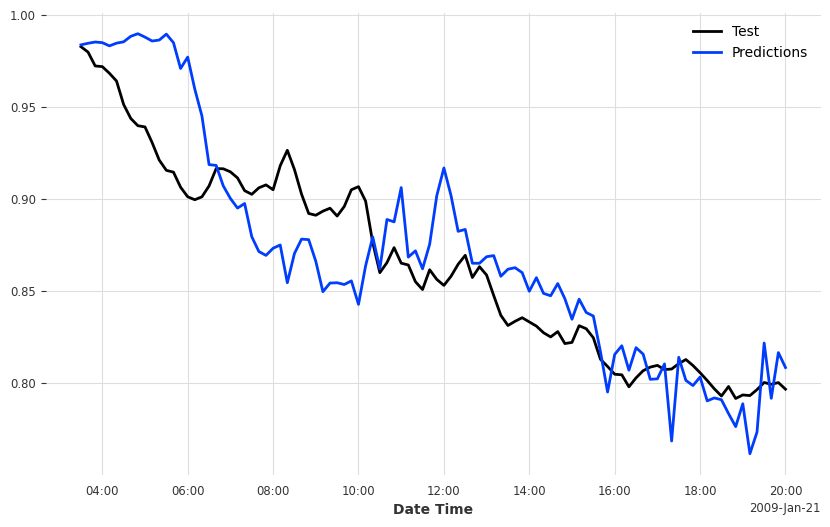

In [61]:
# Plot the results
plt.figure(figsize=(10, 6))
y_test.plot(label="Test")
pred3.plot(label="Predictions")
plt.legend()
plt.show()

In [62]:
nbeats2 = NBEATSModel(
    input_chunk_length=100,
    output_chunk_length=100,
    activation='LeakyReLU',
    n_epochs=27
)
nbeats2.fit(target, past_covariates=past_cov)
pred4 = nbeats2.predict(100)
pred4.values()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 8.4 M  | train
-------------------------------------------------------------
8.4 M     Trainable params
3.1 K     Non-trainable params
8.4 M     Total params
33.672    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=27` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[0.88494561],
       [0.88802923],
       [0.9331949 ],
       [0.92287752],
       [0.9360466 ],
       [0.96070322],
       [0.86700543],
       [0.92259568],
       [0.91966367],
       [0.94955447],
       [0.91421838],
       [0.89059173],
       [0.91264748],
       [0.92733631],
       [0.91593454],
       [0.90158888],
       [0.93497786],
       [0.90151636],
       [0.91487933],
       [0.93248406],
       [0.8711784 ],
       [0.90429729],
       [0.9026778 ],
       [0.89049085],
       [0.93531226],
       [0.94124511],
       [0.87673509],
       [0.92634032],
       [0.93256807],
       [0.90612833],
       [0.91216136],
       [0.88729106],
       [0.92752865],
       [0.93063708],
       [0.92796981],
       [0.90858837],
       [0.85509893],
       [0.87790066],
       [0.89027768],
       [0.90742246],
       [0.86091114],
       [0.92326361],
       [0.8801993 ],
       [0.91023219],
       [0.89712739],
       [0.88829795],
       [0.88386764],
       [0.907

In [63]:
# Compute MAE (Mean Absolute Error)
mae_val = mae(y_test, pred4)
print(f"MAE: {mae_val}")

# Compute RMSE (Root Mean Squared Error)
rmse_val = rmse(y_test, pred4)
print(f"RMSE: {rmse_val}")

# Compute MAPE (Mean Absolute Percentage Error)
mape_val = mape(y_test, pred4)
print(f"MAPE: {mape_val}")

MAE: 0.029993798308716135
RMSE: 0.03662598638766959
MAPE: 3.4873537266983083


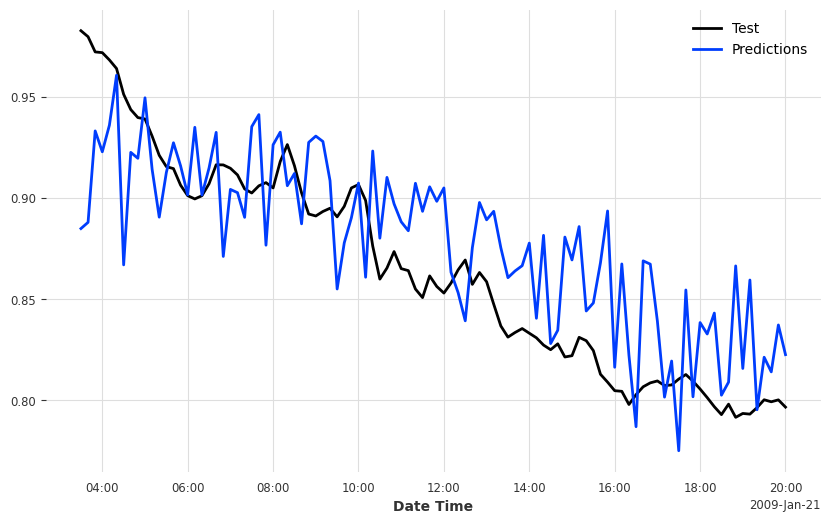

In [64]:
# Plot the results
plt.figure(figsize=(10, 6))
y_test.plot(label="Test")
pred4.plot(label="Predictions")
plt.legend()
plt.show()

# Conclusiones

- Las dos variables más importantes cuyos valores históricos estamos utilizando como variables covariantes pasadas junto con los valores históricos de la variable target para entrenar el mejor modelo son temperature y Airtight.

- La diferenciación estacional(diaria) de la variable target es necesaria para hacerla estacionaria.

- También la transformación logaritmica y el escalado de la variable target han sido necesarias parea lograr un buen performance del modelo, junto con el escalado de las otras variables covariantes pasadas.

- El mejor modelo ha sido el lgbm, tiene un mape menor al 3% y en general del gráfico podemos observar que en general capta la tendencia de los valores futuros de la variable target correctamente a pesar de tener pequeñas fluctuaciones.